# Projeto de Machine Learning

## 1. Case RH - Retenção de funcionários
Objetivo:
Criar um modelo que represente o *Job Satisfaction* de um profissional de TI a partir de características da compania e outros dados obtidos pela pesquisa. Utilize os dados da pesquisa de 2018 do Stackoverflow.

## 2. Case Empresa de Anúncios - Previsão de salários

Objetivo:
Criar um modelo que represente o *Salary* de um profissional de TI a partir de características da compania e outras características dos funcionários utilizando os dados disponibilizados na pesquisa de 2017 do Stackoverflow.


### Passos:

0. Carregar base de dados
1.Seleção de features - Análise das Features / Construir base analítica
  - remover linhas com missing
  - codificar variáveis categóricas como fatores
  - etc.
2. Análise exploratória da Base:
  - Histograma de Salários
  - Histograma de satisfação - Quantos tem satisfação maior que 0.7 
  - Correlações das features, 
  - etc.
4. Traduzir o problema - buscar a melhor solução de negócio
5. Selecionar e treinar o modelo 
  - Selecionar o modelo
  - Definir X (features) e y (variável dependente)
  - Normalizar as features (facultativo, mas melhora os resultados de predição)
  - Separar modelos em treino e teste 
  -Treinar o modelo
6. Retornar MSE para o modelo e distribuição real do seu y_teste e do seu y_pred (y preditos)



# LOAD DATASET

In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn import metrics
pd.set_option('display.max_rows', 3500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data = pd.read_csv("survey_results_public.csv")

# TRATAMENTO DA BASE

#### Elimino linhas que tenham nulos nas colunas Salário, JobSatisfaction, JobSeekingStatus e CarreerSatisfaction

In [25]:
data2 = data[~(data.Salary.isnull() | 
        data.JobSatisfaction.isnull() |
        data.CareerSatisfaction.isnull())]
nrow = data2.shape[0]
print("# Linhas :", nrow)
print("# Colunas: ", data2.shape[1])
del data

# Linhas : 12847
# Colunas:  154


#### Deleto linhas com HoursPerWeek >= 20 ( EmploymentStatus full-time ou part-time) 
(Supondo erro no preenchimento da survey)

In [26]:
data2 = data2[(data2.HoursPerWeek<20)]
print(len(data2))

5540


#### Deleto colunas que possuam mais de 5 mil missing (90%)

In [27]:
del_columns = data2.columns[data2.isnull().sum() >5000]
df = data2.drop(del_columns, axis = 1)
del_columns

Index(['YearsCodedJobPast', 'MobileDeveloperType', 'NonDeveloperType', 'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExCoderActive', 'TimeAfterBootcamp', 'ExpectedSalary'], dtype='object')

In [5]:
#PRINT DO NUMERO DE MISSING POR COLUNA:

#print("data_tratada shape: ", df.shape)
#print("total missing data")
#print()
#for col in df.columns:
#    print(col , df[col].isnull().sum())

#### Deleto algumas colunas que são irrelevantes, que ainda possuem alto valor de missing ou que só possuem um só tipo de resposta (ex: Professional)

In [28]:
#Colunas irrelevantes
df = df.drop("Respondent", axis = 1)
df = df.drop('PronounceGIF', axis = 1)
df = df.drop('ClickyKeys', axis = 1)

#Colunas com alto valor de Missing Data
df = df.drop('HaveWorkedDatabase', axis =1)
df = df.drop('WantWorkDatabase', axis =1)
df = df.drop('HaveWorkedPlatform', axis =1)
df = df.drop('WantWorkPlatform', axis =1)

#Coluna com apenas uma só resposta
df = df.drop("Professional", axis = 1)

#### Transformo as colunas com múltiplas respostas em dummies


HaveWorkedLanguage, WantWorkLanguage, IDE, DeveloperType e ImportantBenefits, Gender, Race, StackOverflowDevices, MetricAssess, EducationTypes


In [29]:
def strip_lista(lista):
    return list(map(str.strip,lista))

def get_dummy_cols(df, column_string, prefix = "uses"):
    df1 = df[column_string].str.split(';').dropna()
    df1 = df1.apply(lambda x: strip_lista(x))
    df2 = pd.get_dummies(df1.apply(pd.Series).stack()).sum(level=0)
    df = df.drop(column_string, axis = 1)
    df2.columns = [prefix +"_"+ x for x in df2.columns]     
    result = pd.merge(df,df2,left_index=True,right_index=True)
    return result


df = get_dummy_cols(df,'HaveWorkedLanguage', prefix ='Worked_with')
df = get_dummy_cols(df,'WantWorkLanguage', prefix = 'Want_work')
df = get_dummy_cols(df,'IDE' ,prefix = 'Uses')
df = get_dummy_cols(df, "DeveloperType", prefix = "DevType")
df = get_dummy_cols(df,'ImportantBenefits' ,prefix = 'IsImportantBenefit')
df = get_dummy_cols(df,'Gender' ,prefix = 'Gender')
df = get_dummy_cols(df, 'Race', prefix = "Race")
df = get_dummy_cols(df, 'StackOverflowDevices', prefix = "Uses_StackOverflow_in")
df = get_dummy_cols(df, 'MetricAssess', prefix = "MetricAssess_")
df = get_dummy_cols(df, 'EducationTypes', prefix = "Education")

print(df.shape)
df.head(1)

(1928, 288)


,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,CompanyType,YearsProgram,YearsCodedJob,WebDeveloperType,CareerSatisfaction,JobSatisfaction,ProblemSolving,BuildingThings,LearningNewTech,BoringDetails,JobSecurity,DiversityImportant,AnnoyingUI,FriendsDevelopers,RightWrongWay,UnderstandComputers,SeriousWork,InvestTimeTools,WorkPayCare,KinshipDevelopers,ChallengeMyself,CompetePeers,ChangeWorld,JobSeekingStatus,HoursPerWeek,LastNewJob,AssessJobIndustry,AssessJobRole,AssessJobExp,AssessJobDept,AssessJobTech,AssessJobProjects,AssessJobCompensation,AssessJobOffice,AssessJobCommute,AssessJobRemote,AssessJobLeaders,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,JobProfile,ResumePrompted,LearnedHiring,ImportantHiringAlgorithms,ImportantHiringTechExp,ImportantHiringCommunication,ImportantHiringOpenSource,ImportantHiringPMExp,ImportantHiringCompanies,ImportantHiringTitles,ImportantHiringEducation,ImportantHiringRep,ImportantHiringGettingThingsDone,Currency,Overpaid,TabsSpaces,EducationImportant,SelfTaughtTypes,CousinEducation,WorkStart,HaveWorkedFramework,WantWorkFramework,AuditoryEnvironment,Methodology,VersionControl,CheckInCode,ShipIt,OtherPeoplesCode,ProjectManagement,EnjoyDebugging,InTheZone,DifficultCommunication,CollaborateRemote,EquipmentSatisfiedMonitors,EquipmentSatisfiedCPU,EquipmentSatisfiedRAM,EquipmentSatisfiedStorage,EquipmentSatisfiedRW,InfluenceInternet,InfluenceWorkstation,InfluenceHardware,InfluenceServers,InfluenceTechStack,InfluenceDeptTech,InfluenceVizTools,InfluenceDatabase,InfluenceCloud,InfluenceConsultants,InfluenceRecruitment,InfluenceCommunication,StackOverflowDescribes,StackOverflowSatisfaction,StackOverflowFoundAnswer,StackOverflowCopiedCode,StackOverflowJobListing,StackOverflowCompanyPage,StackOverflowJobSearch,StackOverflowNewQuestion,StackOverflowAnswer,StackOverflowMetaChat,StackOverflowAdsRelevant,StackOverflowAdsDistracting,StackOverflowModeration,StackOverflowCommunity,StackOverflowHelpful,StackOverflowBetter,StackOverflowWhatDo,StackOverflowMakeMoney,HighestEducationParents,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,Worked_with_Assembly,Worked_with_C,Worked_with_C#,Worked_with_C++,Worked_with_Clojure,Worked_with_CoffeeScript,Worked_with_Common Lisp,Worked_with_Dart,Worked_with_Elixir,Worked_with_Erlang,Worked_with_F#,Worked_with_Go,Worked_with_Groovy,Worked_with_Hack,Worked_with_Haskell,Worked_with_Java,Worked_with_JavaScript,Worked_with_Julia,Worked_with_Lua,Worked_with_Matlab,Worked_with_Objective-C,Worked_with_PHP,Worked_with_Perl,Worked_with_Python,Worked_with_R,Worked_with_Ruby,Worked_with_Rust,Worked_with_SQL,Worked_with_Scala,Worked_with_Smalltalk,Worked_with_Swift,Worked_with_TypeScript,Worked_with_VB.NET,Worked_with_VBA,Worked_with_Visual Basic 6,Want_work_Assembly,Want_work_C,Want_work_C#,Want_work_C++,Want_work_Clojure,Want_work_CoffeeScript,Want_work_Common Lisp,Want_work_Dart,Want_work_Elixir,Want_work_Erlang,Want_work_F#,Want_work_Go,Want_work_Groovy,Want_work_Hack,Want_work_Haskell,Want_work_Java,Want_work_JavaScript,Want_work_Julia,Want_work_Lua,Want_work_Matlab,Want_work_Objective-C,Want_work_PHP,Want_work_Perl,Want_work_Python,Want_work_R,Want_work_Ruby,Want_work_Rust,Want_work_SQL,Want_work_Scala,Want_work_Smalltalk,Want_work_Swift,Want_work_TypeScript,Want_work_VB.NET,Want_work_VBA,Want_work_Visual Basic 6,Uses_Android Studio,Uses_Atom,Uses_Coda,Uses_Eclipse,Uses_Emacs,Uses_IPython / Jupyter,Uses_IntelliJ,Uses_Komodo,Uses_Light Table,Uses_NetBeans,Uses_Notepad++,Uses_PHPStorm,Uses_PyCharm,Uses_RStudio,Uses_RubyMine,Uses_Sublime Text,Uses_TextMate,Uses_Vim,Uses_Visual Studio,Uses_Visual Studio Code,Uses_Xcode,Uses_Zend,DevType_Data scientist,DevType_Database administrator,DevType_Desktop applications developer,DevType_DevOps specialist,DevType_Developer with a statistics or mathematics background,DevType_Embedded applications/devices developer,DevType_Graphic designer,Dev

### FIM DO PRE TRATAMENTO


In [30]:
df.to_csv("data_tratada.csv")

#### Transformo as variáveis não numéricas em Dummies

In [8]:
#only numeric columns

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics)
numeric_columns.columns

Index(['CareerSatisfaction', 'JobSatisfaction', 'HoursPerWeek', 'StackOverflowSatisfaction', 'Salary'], dtype='object')

In [9]:
#Colunas com prefixos (as colunas que já foram transformadas em dummies) não entram no get_dummies
prefix_list = ["Worked_with_","Want_work_","Uses_","DevType_","Uses_","IsImportantBenefit_","Gender_",
              "Race_","Uses_StackOverflow_in","MetricAssess_","Education_"]

already_dummies = []
for prefix in prefix_list:
    already_dummies += [col for col in df.columns.values if prefix in col]

print("Colunas que já são dummies:", len(already_dummies) )

Colunas que já são dummies: 199


In [10]:
not_numeric = [x for x in df.columns.values if x not in numeric_columns]
to_dummies = [x for x in not_numeric if x not in already_dummies]

X = pd.get_dummies(df, columns=to_dummies)
print(X.shape)

(1928, 2297)


#### Separo em X = Colunas de df menos a Salary e Y = sqrt(Salary) 

In [12]:
print("Antes: ", len(X))
X = X[X["Salary"]!=0]
y  = np.sqrt(X["Salary"])
X = X.drop('Salary',axis = 1)
print(len(y))

Antes:  1928
1928


# Plotar hist(Salary) e sqrt(salary) --justificar  *****

#### Elimino variáveis com pouca variedade (binárias com menos de 200 valores 1 em X)

In [13]:
print(X.shape)
not_numeric = [col for col in X.columns.values if col not in numeric_columns.columns.values]
cols = [col for col in not_numeric if X[col].sum()>50]
X = X[cols]
print(X.shape)

(1928, 2296)
(1928, 648)


#### Separo em Train e Test e Normalizo colunas numericas

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

#### Treino Modelo Linear

In [15]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
# Predict
y_pred = lm.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test**2, y_pred**2)))

26729.1469673


NormaltestResult(statistic=11.214060584695865, pvalue=0.0036719578231947524)

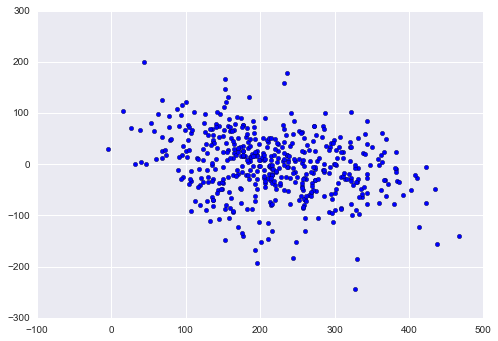

In [22]:
import scipy
res = y_test - y_pred
plt.scatter(y_pred,res)
scipy.stats.normaltest(res)

(array([   1.,    5.,   15.,   49.,  107.,  139.,  108.,   46.,    8.,    4.]),
 array([-244.19193669, -199.68097059, -155.17000449, -110.6590384 ,
         -66.1480723 ,  -21.6371062 ,   22.87385989,   67.38482599,
         111.89579209,  156.40675818,  200.91772428]),
 <a list of 10 Patch objects>)

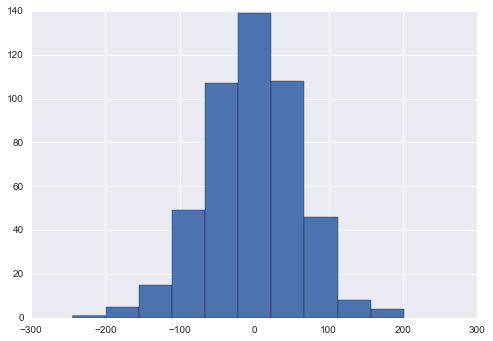

In [18]:
plt.hist(res)

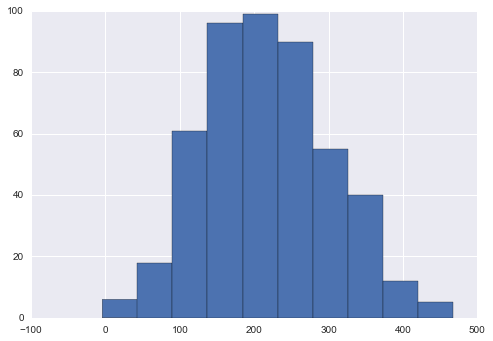

In [19]:
y_predicted = pd.DataFrame()
y_predicted["y_pred"] = y_pred
y_predicted["y_pred"].hist()

(array([ 100.,  133.,   87.,   66.,   46.,   23.,   17.,    5.,    4.,    1.]),
 array([  1.85976562e+01,   2.18168825e+04,   4.36151674e+04,
          6.54134522e+04,   8.72117371e+04,   1.09010022e+05,
          1.30808307e+05,   1.52606592e+05,   1.74404877e+05,
          1.96203161e+05,   2.18001446e+05]),
 <a list of 10 Patch objects>)

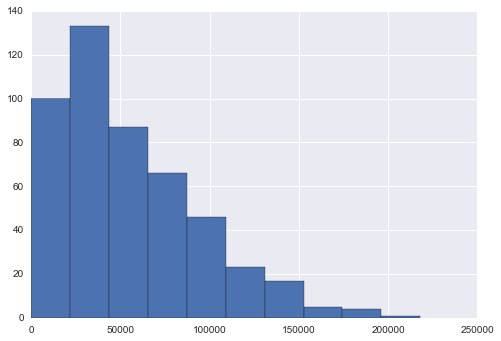

In [20]:
plt.hist(y_pred*y_pred)

(array([  96.,   82.,  115.,   64.,   47.,   29.,   21.,   14.,    8.,    6.]),
 array([  6.77495006e+00,   1.84060975e+04,   3.68054200e+04,
          5.52047425e+04,   7.36040650e+04,   9.20033875e+04,
          1.10402710e+05,   1.28802032e+05,   1.47201355e+05,
          1.65600677e+05,   1.84000000e+05]),
 <a list of 10 Patch objects>)

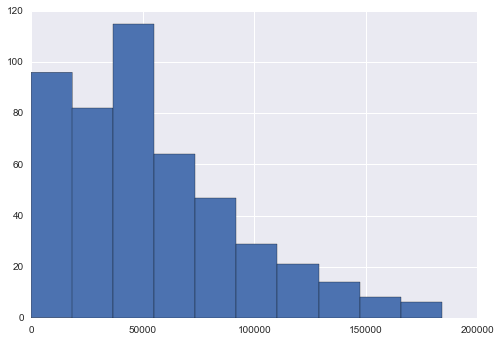

In [21]:
plt.hist(y_test*y_test)

# LASSO

In [ ]:
#SALARIO - LASSO
from sklearn.linear_model import LassoCV
  
lasso = LassoCV(tol=.01, normalize=True, fit_intercept=True)
lasso.fit(X_train, y_train)
  
# Predict
y_pred = lasso.predict(X_test) 

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test**2, y_pred**2)))

In [ ]:
res = y_test**2 - y_pred**2
plt.hist(res)

In [ ]:
import scipy

scipy.stats.normaltest(res)

In [ ]:
y_predicted = pd.DataFrame()
y_predicted["y_pred"] = y_pred
y_predicted["y_pred"].hist()

In [ ]:
plt.hist(y_pred*y_pred)

In [ ]:
plt.hist(y_test*y_test)

## RIDGE

In [ ]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV()
clf.fit(X_train, y_train)
  
# Predict
y_pred = clf.predict(X_test)  #OBS TIVE QUE COLOCAR UM MÓDULO (ABS) NOS RESULTADOS

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test**2, y_pred**2)))

In [ ]:
res = y_test**2 - y_pred**2
plt.hist(res)

In [ ]:
y_predicted = pd.DataFrame()
y_predicted["y_pred"] = y_pred
y_predicted["y_pred"].hist()

In [ ]:
plt.hist(y_pred*y_pred)

In [ ]:
plt.hist(y_test*y_test)


In [ ]:
df.to_csv("data_tratada.csv")